In [1]:
import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split

from datetime import datetime

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler

import range_classification__config as cfg

from range_classification__dataset import RangeClassificationSameUniformDiffDataset, RangeClassificationMixedUniformDiffDataset, RangeClassificationMimicDiffDataset, get_error_constrained_dataset
from Common.Datasets.Morph2.data_parser import DataParser
from range_classification__train import train_diff_cls_model_iter


from range_classification__model import RangeClassificationModel, RangeClassificationDeepModel

from tqdm import tqdm

from sklearn import utils



#####################################################
#           Preparations
#####################################################

torch.manual_seed(cfg.RANDOM_SEED)
np.random.seed(cfg.RANDOM_SEED)
random.seed(cfg.RANDOM_SEED)

if cfg.USE_GPU:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(device)

torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

with open("im2age_map_test.json", 'r') as im2age_map_test_f:
    im2age_map_test = json.load(im2age_map_test_f)

# Load data
data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
data_parser.initialize_data()


x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,
if cfg.RANDOM_SPLIT:
    all_images = np.concatenate((x_train, x_test), axis=0)
    all_labels = np.concatenate((y_train, y_test), axis=0)

    x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)




cuda:0


In [2]:
import matplotlib.pyplot as plt

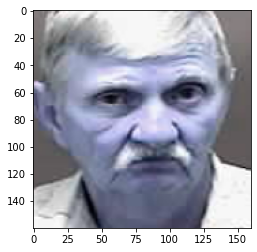

In [3]:
x_train[0].shape
plt.imshow(x_train[0])


In [4]:
# shuffle basic aligned test
# x_test_shuffled
# y_test_shuffled


transf = transforms.Compose([
          transforms.Resize(224), # just for testing
#          transforms.RandomResizedCrop(224, (0.9, 1.0)),
#          transforms.RandomHorizontalFlip(),
#         transforms.RandomApply([transforms.ColorJitter(
#             brightness=0.1,
#             contrast=0.1,
#             saturation=0.1,
#             hue=0.1
#         )], p=0.5),
#         transforms.RandomApply([transforms.RandomAffine(
#             degrees=10,
#             translate=(0.1, 0.1),
#             scale=(0.9, 1.1),
#             shear=5,
#             resample=Image.BICUBIC
#         )], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#        transforms.RandomErasing(p=0.5)
    ])

train_ds = RangeClassificationSameUniformDiffDataset(
    data_set_images=x_train,
    data_set_metadata=y_train,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI
)

print("Training (q trn, r trn) set size: " + str(len(train_ds)))

test_qtst_rtst_ds = RangeClassificationSameUniformDiffDataset(
    data_set_images=x_test,
    data_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI
)

print("Testing (q tst, r tst) set size: " + str(len(test_qtst_rtst_ds)))

test_qtst_rtrn_ds = RangeClassificationMixedUniformDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test,
    batst_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI
)

print("Testing (q tst, r trn) set size: " + str(len(test_qtst_rtrn_ds)))

x_test_filtered, y_test_filtered, batst_set_filtered_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI,
                                                                                                im2age_map_batst=im2age_map_test)

#apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
test_apref_ds = RangeClassificationMimicDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test_filtered,
    batst_set_metadata=y_test_filtered,
    batst_set_indexes=batst_set_filtered_indexes,
    im2age_map_batst=im2age_map_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS
)

print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI) + str(len(test_apref_ds)))


image_datasets = {
    'train': train_ds,
    'val_qtst_rtst': test_qtst_rtst_ds,
    'val_qtst_rtrn': test_qtst_rtrn_ds,
    'val_apref_ds': test_apref_ds
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val_qtst_rtst', 'val_qtst_rtrn', 'val_apref_ds']}

data_loaders = {
    'train': DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=True, drop_last=True),
    'val_qtst_rtst': DataLoader(test_qtst_rtst_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_qtst_rtrn': DataLoader(test_qtst_rtrn_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_apref_ds': DataLoader(test_apref_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True)
}




Training (q trn, r trn) set size: 44285
Testing (q tst, r tst) set size: 10606
Testing (q tst, r trn) set size: 10606
Testing (q tst where AgePredict(q)  0 <= error <= 35, r trn where age(r)=AgePredict(q)) set size: 10606


In [5]:
samples = []
for i, batch in enumerate(data_loaders['train']):
    samples.append(batch)
    if i == 100:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


          2.0                    -7.0                    19.0                    18.0          


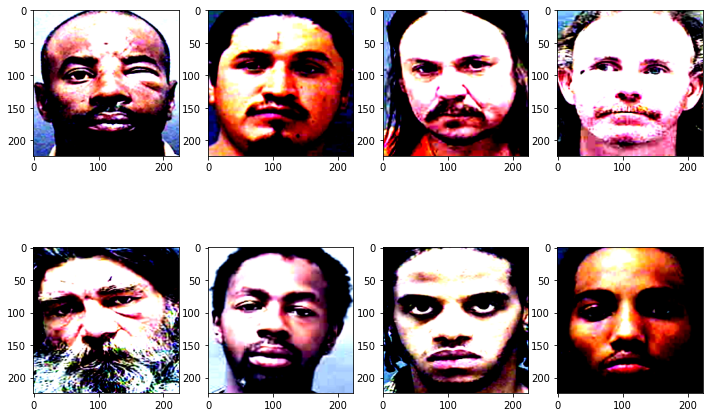

In [6]:
#print(batch['image_vec'][0][0].reshape((224,224,3)).shape)
#samples[0]['image_vec'].shape
#print(samples[0]['bla'])
fig, ax = plt.subplots(2, 4, figsize=(12, 8))

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(samples[0]['image_vec'][j][i].permute(1, 2, 0).numpy())
        
diffs_str = ""
for j in range(4):
    diffs_str += "          " + str(float(samples[0]['age_diff'][j])) + "          "

print(diffs_str)

# plt.imshow(samples[0]['image_vec'][0][0].permute(1, 2, 0).numpy())
# plt.imshow(samples[0]['image_vec'][0][1].permute(1, 2, 0).numpy())
#plt.imshow(samples[0]['image_vec'][0][0].reshape((160,160,3)))
#plt.imshow(samples[0]['image_vec'][0][0].reshape((224,224,3)))
#plt.imshow(samples[0]['image_vec'][0][1].reshape((224,224,3)))

In [7]:
#####################################################
#           Model
#####################################################


# create model and parameters
if cfg.DEEP_MODEL:
    model = RangeClassificationDeepModel(age_interval=cfg.AGE_INTERVAL, 
                            min_age=cfg.MIN_AGE, 
                            max_age=cfg.MAX_AGE, 
                            age_radius=cfg.AGE_RADIUS, 
                            device=device)
else:
    model = RangeClassificationModel(age_interval=cfg.AGE_INTERVAL, 
                            min_age=cfg.MIN_AGE, 
                            max_age=cfg.MAX_AGE, 
                            age_radius=cfg.AGE_RADIUS, 
                            device=device)


if cfg.UNFREEZE_FEATURE_EXT_ON_RLVNT_EPOCH:
    model.freeze_base_cnn(True)

if cfg.USE_GPU and cfg.MULTI_GPU:
    if torch.cuda.device_count() > 1:
        print("Using multiple GPUs (" + str(torch.cuda.device_count()) + ")")
        model = torch.nn.DataParallel(model)

model.to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)

if cfg.OPTIMIZER == "RangerLars":
    optimizer = RangerLars(model.parameters(), lr=cfg.LEARNING_RATE)
else:
    optimizer = Adam(model.parameters(), lr=cfg.LEARNING_RATE)

if cfg.SCHEDULER == "CosineAnnealingLR+GradualWarmupScheduler":
    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=cfg.NUM_ITERS
    )
    scheduler = GradualWarmupScheduler(
        optimizer,
        multiplier=1,
        total_epoch=10000,
        after_scheduler=cosine_scheduler
    )
else:
    scheduler = None


    

Using multiple GPUs (2)


  0%|                                                                                         | 0/5535 [00:00<?, ?it/s]

Epoch 0/199
----------


C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  2%|█▋                                                                             | 120/5535 [01:10<51:04,  1.77it/s]

train Loss: 1.1028 Accuracy: 0.3708


  4%|███▍                                                                           | 240/5535 [02:19<49:52,  1.77it/s]

train Loss: 1.1015 Accuracy: 0.3271


  7%|█████▏                                                                         | 360/5535 [03:27<48:27,  1.78it/s]

train Loss: 1.1002 Accuracy: 0.3490


  9%|██████▊                                                                        | 480/5535 [04:35<47:57,  1.76it/s]

train Loss: 1.0901 Accuracy: 0.3667


 11%|████████▌                                                                      | 600/5535 [05:43<46:42,  1.76it/s]

train Loss: 1.0905 Accuracy: 0.3854


 13%|██████████▎                                                                    | 720/5535 [06:51<45:26,  1.77it/s]

train Loss: 1.0571 Accuracy: 0.4260


 15%|███████████▉                                                                   | 840/5535 [07:59<44:33,  1.76it/s]

train Loss: 1.0120 Accuracy: 0.4917


 17%|█████████████▋                                                                 | 960/5535 [09:07<43:16,  1.76it/s]

train Loss: 1.0037 Accuracy: 0.4760


 20%|███████████████▏                                                              | 1080/5535 [10:15<42:20,  1.75it/s]

train Loss: 0.9974 Accuracy: 0.4802


 22%|████████████████▉                                                             | 1200/5535 [11:23<41:05,  1.76it/s]

train Loss: 0.9685 Accuracy: 0.4792


 24%|██████████████████▌                                                           | 1320/5535 [12:31<39:58,  1.76it/s]

train Loss: 0.9502 Accuracy: 0.5042


 26%|████████████████████▎                                                         | 1440/5535 [13:39<38:43,  1.76it/s]

train Loss: 0.9115 Accuracy: 0.5208


 28%|█████████████████████▉                                                        | 1560/5535 [14:47<37:38,  1.76it/s]

train Loss: 0.9753 Accuracy: 0.5073


 30%|███████████████████████▋                                                      | 1680/5535 [15:55<36:24,  1.76it/s]

train Loss: 0.9468 Accuracy: 0.5302


 33%|█████████████████████████▎                                                    | 1800/5535 [17:03<35:15,  1.77it/s]

train Loss: 0.9432 Accuracy: 0.5417


 35%|███████████████████████████                                                   | 1920/5535 [18:11<33:52,  1.78it/s]

train Loss: 0.9279 Accuracy: 0.5281


 37%|████████████████████████████▋                                                 | 2040/5535 [19:19<33:03,  1.76it/s]

train Loss: 0.9313 Accuracy: 0.5021


 39%|██████████████████████████████▍                                               | 2160/5535 [20:27<31:49,  1.77it/s]

train Loss: 0.9617 Accuracy: 0.4823


 41%|████████████████████████████████▏                                             | 2280/5535 [21:35<30:50,  1.76it/s]

train Loss: 0.9196 Accuracy: 0.5479


 43%|█████████████████████████████████▊                                            | 2400/5535 [22:43<29:29,  1.77it/s]

train Loss: 0.9337 Accuracy: 0.4948


 46%|███████████████████████████████████▌                                          | 2520/5535 [23:51<28:33,  1.76it/s]

train Loss: 0.9325 Accuracy: 0.5188


 48%|█████████████████████████████████████▏                                        | 2640/5535 [24:59<27:09,  1.78it/s]

train Loss: 0.9152 Accuracy: 0.5198


 50%|██████████████████████████████████████▉                                       | 2760/5535 [26:07<26:10,  1.77it/s]

train Loss: 0.9269 Accuracy: 0.5396


 52%|████████████████████████████████████████▌                                     | 2880/5535 [27:15<25:05,  1.76it/s]

train Loss: 0.9394 Accuracy: 0.4948


 54%|██████████████████████████████████████████▎                                   | 3000/5535 [28:23<23:57,  1.76it/s]

train Loss: 0.9273 Accuracy: 0.4958


 56%|███████████████████████████████████████████▉                                  | 3120/5535 [29:31<22:40,  1.78it/s]

train Loss: 0.9329 Accuracy: 0.5062


 59%|█████████████████████████████████████████████▋                                | 3240/5535 [30:39<21:36,  1.77it/s]

train Loss: 0.9359 Accuracy: 0.5104


 61%|███████████████████████████████████████████████▎                              | 3360/5535 [31:47<20:29,  1.77it/s]

train Loss: 0.9327 Accuracy: 0.5281


 63%|█████████████████████████████████████████████████                             | 3480/5535 [32:55<19:20,  1.77it/s]

train Loss: 0.9161 Accuracy: 0.5417


 65%|██████████████████████████████████████████████████▋                           | 3600/5535 [34:03<18:07,  1.78it/s]

train Loss: 0.9067 Accuracy: 0.5281


 67%|████████████████████████████████████████████████████▍                         | 3720/5535 [35:11<17:11,  1.76it/s]

train Loss: 0.9169 Accuracy: 0.5115


 69%|██████████████████████████████████████████████████████                        | 3840/5535 [36:19<16:06,  1.75it/s]

train Loss: 0.9180 Accuracy: 0.5437


 72%|███████████████████████████████████████████████████████▊                      | 3960/5535 [37:27<14:53,  1.76it/s]

train Loss: 0.9355 Accuracy: 0.5083


 74%|█████████████████████████████████████████████████████████▍                    | 4080/5535 [38:35<14:00,  1.73it/s]

train Loss: 0.9058 Accuracy: 0.5104


 76%|███████████████████████████████████████████████████████████▏                  | 4200/5535 [39:43<12:39,  1.76it/s]

train Loss: 0.9179 Accuracy: 0.5219


 78%|████████████████████████████████████████████████████████████▉                 | 4320/5535 [40:51<11:24,  1.77it/s]

train Loss: 0.9118 Accuracy: 0.5281


 80%|██████████████████████████████████████████████████████████████▌               | 4440/5535 [41:59<10:22,  1.76it/s]

train Loss: 0.9084 Accuracy: 0.5302


 82%|████████████████████████████████████████████████████████████████▎             | 4560/5535 [43:07<09:14,  1.76it/s]

train Loss: 0.9077 Accuracy: 0.5448


 85%|█████████████████████████████████████████████████████████████████▉            | 4680/5535 [44:15<08:06,  1.76it/s]

train Loss: 0.8903 Accuracy: 0.5094


 87%|███████████████████████████████████████████████████████████████████▋          | 4800/5535 [45:23<06:55,  1.77it/s]

train Loss: 0.8901 Accuracy: 0.5417


 89%|█████████████████████████████████████████████████████████████████████▎        | 4920/5535 [46:31<05:47,  1.77it/s]

train Loss: 0.8872 Accuracy: 0.5375


 91%|███████████████████████████████████████████████████████████████████████       | 5040/5535 [47:39<04:40,  1.77it/s]

train Loss: 0.9268 Accuracy: 0.5323


 93%|████████████████████████████████████████████████████████████████████████▋     | 5160/5535 [48:47<03:31,  1.77it/s]

train Loss: 0.9025 Accuracy: 0.5250


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5280/5535 [49:55<02:24,  1.76it/s]

train Loss: 0.9293 Accuracy: 0.5208


 98%|████████████████████████████████████████████████████████████████████████████  | 5400/5535 [51:03<01:16,  1.76it/s]

train Loss: 0.9205 Accuracy: 0.5010


100%|█████████████████████████████████████████████████████████████████████████████▊| 5520/5535 [52:11<00:08,  1.76it/s]

train Loss: 0.9267 Accuracy: 0.5135


100%|██████████████████████████████████████████████████████████████████████████████| 5535/5535 [32:47<00:00,  2.81it/s]


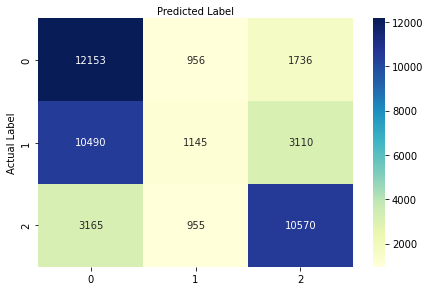

running on validation (val_apref_ds) set...


  0%|                                                                                         | 0/1325 [00:00<?, ?it/s]

val_apref_ds Loss: 0.8625 Accuracy: 0.6555


100%|██████████████████████████████████████████████████████████████████████████████| 1325/1325 [07:46<00:00,  2.84it/s]


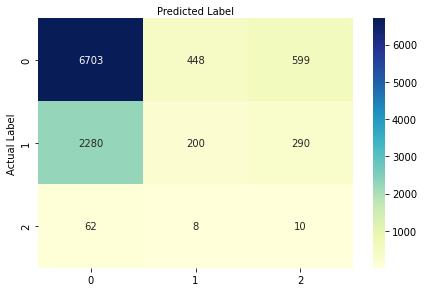

  0%|                                                                                         | 0/5535 [00:00<?, ?it/s]


Epoch 1/199
----------


C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  2%|█▍                                                                             | 105/5535 [00:59<51:01,  1.77it/s]

train Loss: 0.9032 Accuracy: 0.5333


  4%|███▏                                                                           | 225/5535 [02:07<50:25,  1.76it/s]

train Loss: 0.9195 Accuracy: 0.5271


  6%|████▉                                                                          | 345/5535 [03:15<48:52,  1.77it/s]

train Loss: 0.9084 Accuracy: 0.5615


  8%|██████▋                                                                        | 465/5535 [04:23<47:31,  1.78it/s]

train Loss: 0.9142 Accuracy: 0.5188


 11%|████████▎                                                                      | 585/5535 [05:31<46:28,  1.78it/s]

train Loss: 0.8887 Accuracy: 0.5365


 13%|██████████                                                                     | 705/5535 [06:39<45:21,  1.77it/s]

train Loss: 0.8923 Accuracy: 0.5427


 15%|███████████▊                                                                   | 825/5535 [07:47<44:28,  1.77it/s]

train Loss: 0.9177 Accuracy: 0.5167


 17%|█████████████▍                                                                 | 945/5535 [08:55<43:06,  1.77it/s]

train Loss: 0.9184 Accuracy: 0.5146


 19%|███████████████                                                               | 1065/5535 [10:03<42:13,  1.76it/s]

train Loss: 0.9177 Accuracy: 0.5281


 21%|████████████████▋                                                             | 1185/5535 [11:11<40:56,  1.77it/s]

train Loss: 0.9213 Accuracy: 0.5062


 24%|██████████████████▍                                                           | 1305/5535 [12:19<39:43,  1.77it/s]

train Loss: 0.9535 Accuracy: 0.5156


 26%|████████████████████                                                          | 1425/5535 [13:27<38:42,  1.77it/s]

train Loss: 0.8785 Accuracy: 0.5312


 28%|█████████████████████▊                                                        | 1545/5535 [14:35<37:29,  1.77it/s]

train Loss: 0.9149 Accuracy: 0.5458


 30%|███████████████████████▍                                                      | 1665/5535 [15:43<36:41,  1.76it/s]

train Loss: 0.8880 Accuracy: 0.5635


 32%|█████████████████████████▏                                                    | 1785/5535 [16:51<35:27,  1.76it/s]

train Loss: 0.8911 Accuracy: 0.5333


 34%|██████████████████████████▊                                                   | 1905/5535 [17:58<34:12,  1.77it/s]

train Loss: 0.9126 Accuracy: 0.5177


 37%|████████████████████████████▌                                                 | 2025/5535 [19:06<33:00,  1.77it/s]

train Loss: 0.9037 Accuracy: 0.5323


 39%|██████████████████████████████▏                                               | 2145/5535 [20:14<32:02,  1.76it/s]

train Loss: 0.8867 Accuracy: 0.5385


 41%|███████████████████████████████▉                                              | 2265/5535 [21:22<30:51,  1.77it/s]

train Loss: 0.8923 Accuracy: 0.4990


 43%|█████████████████████████████████▌                                            | 2385/5535 [22:30<29:51,  1.76it/s]

train Loss: 0.8602 Accuracy: 0.5719


 45%|███████████████████████████████████▎                                          | 2505/5535 [23:38<28:34,  1.77it/s]

train Loss: 0.9059 Accuracy: 0.5312


 47%|████████████████████████████████████▉                                         | 2625/5535 [24:46<27:21,  1.77it/s]

train Loss: 0.9277 Accuracy: 0.5417


 50%|██████████████████████████████████████▋                                       | 2745/5535 [25:54<26:07,  1.78it/s]

train Loss: 0.8706 Accuracy: 0.5500


 52%|████████████████████████████████████████▎                                     | 2865/5535 [27:02<25:12,  1.76it/s]

train Loss: 0.8786 Accuracy: 0.5531


 54%|██████████████████████████████████████████                                    | 2985/5535 [28:10<24:04,  1.77it/s]

train Loss: 0.8930 Accuracy: 0.5406


 56%|███████████████████████████████████████████▊                                  | 3105/5535 [29:18<22:56,  1.76it/s]

train Loss: 0.8933 Accuracy: 0.5406


 58%|█████████████████████████████████████████████▍                                | 3225/5535 [30:26<21:49,  1.76it/s]

train Loss: 0.8771 Accuracy: 0.5458


 60%|███████████████████████████████████████████████▏                              | 3345/5535 [31:34<20:41,  1.76it/s]

train Loss: 0.8930 Accuracy: 0.5312


 63%|████████████████████████████████████████████████▊                             | 3465/5535 [32:42<19:39,  1.75it/s]

train Loss: 0.8936 Accuracy: 0.5510


 65%|██████████████████████████████████████████████████▌                           | 3585/5535 [33:50<18:26,  1.76it/s]

train Loss: 0.9097 Accuracy: 0.5208


 67%|████████████████████████████████████████████████████▏                         | 3705/5535 [34:58<17:20,  1.76it/s]

train Loss: 0.9059 Accuracy: 0.5344


 69%|█████████████████████████████████████████████████████▉                        | 3825/5535 [36:06<16:05,  1.77it/s]

train Loss: 0.9100 Accuracy: 0.5312


 71%|███████████████████████████████████████████████████████▌                      | 3945/5535 [37:14<15:05,  1.76it/s]

train Loss: 0.8807 Accuracy: 0.5490


 73%|█████████████████████████████████████████████████████████▎                    | 4065/5535 [38:22<13:56,  1.76it/s]

train Loss: 0.8954 Accuracy: 0.5406


 76%|██████████████████████████████████████████████████████████▉                   | 4185/5535 [39:30<12:46,  1.76it/s]

train Loss: 0.8781 Accuracy: 0.5479


 78%|████████████████████████████████████████████████████████████▋                 | 4305/5535 [40:38<11:34,  1.77it/s]

train Loss: 0.9316 Accuracy: 0.5323


 80%|██████████████████████████████████████████████████████████████▎               | 4425/5535 [41:46<10:28,  1.77it/s]

train Loss: 0.8881 Accuracy: 0.5458


 82%|████████████████████████████████████████████████████████████████              | 4545/5535 [42:54<09:20,  1.77it/s]

train Loss: 0.9000 Accuracy: 0.5427


 84%|█████████████████████████████████████████████████████████████████▋            | 4665/5535 [44:02<08:15,  1.76it/s]

train Loss: 0.8879 Accuracy: 0.5469


 86%|███████████████████████████████████████████████████████████████████▍          | 4785/5535 [45:10<07:07,  1.75it/s]

train Loss: 0.9012 Accuracy: 0.5396


 89%|█████████████████████████████████████████████████████████████████████         | 4905/5535 [46:18<05:55,  1.77it/s]

train Loss: 0.9274 Accuracy: 0.5198


 91%|██████████████████████████████████████████████████████████████████████▊       | 5025/5535 [47:26<04:49,  1.76it/s]

train Loss: 0.8837 Accuracy: 0.5490


 93%|████████████████████████████████████████████████████████████████████████▌     | 5145/5535 [48:33<03:41,  1.76it/s]

train Loss: 0.9144 Accuracy: 0.5281


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5265/5535 [49:41<02:32,  1.77it/s]

train Loss: 0.9309 Accuracy: 0.5052


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5385/5535 [50:49<01:24,  1.77it/s]

train Loss: 0.8808 Accuracy: 0.5135


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5505/5535 [51:57<00:16,  1.77it/s]

train Loss: 0.8690 Accuracy: 0.5521


100%|██████████████████████████████████████████████████████████████████████████████| 5535/5535 [32:53<00:00,  2.80it/s]


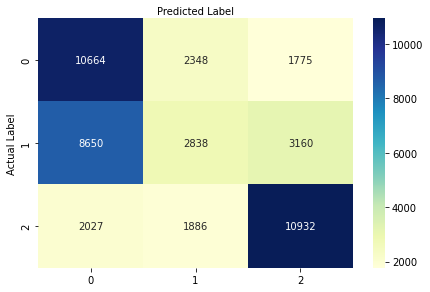

running on validation (val_apref_ds) set...


  0%|                                                                                         | 0/1325 [00:00<?, ?it/s]

val_apref_ds Loss: 0.9032 Accuracy: 0.6169


100%|██████████████████████████████████████████████████████████████████████████████| 1325/1325 [07:47<00:00,  2.84it/s]


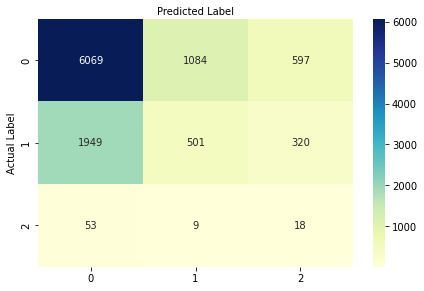

  0%|                                                                                         | 0/5535 [00:00<?, ?it/s]


Epoch 2/199
----------


C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  2%|█▎                                                                              | 90/5535 [00:50<51:22,  1.77it/s]

train Loss: 0.9223 Accuracy: 0.5229


  4%|██▉                                                                            | 210/5535 [01:58<50:26,  1.76it/s]

train Loss: 0.9346 Accuracy: 0.5563


  6%|████▋                                                                          | 330/5535 [03:06<49:31,  1.75it/s]

train Loss: 0.9118 Accuracy: 0.5448


  8%|██████▍                                                                        | 450/5535 [04:14<47:59,  1.77it/s]

train Loss: 0.9190 Accuracy: 0.5083


 10%|████████▏                                                                      | 570/5535 [05:22<47:03,  1.76it/s]

train Loss: 0.8995 Accuracy: 0.5312


 12%|█████████▊                                                                     | 690/5535 [06:30<45:57,  1.76it/s]

train Loss: 0.9483 Accuracy: 0.5010


 15%|███████████▌                                                                   | 810/5535 [07:38<44:09,  1.78it/s]

train Loss: 0.8903 Accuracy: 0.5083


 17%|█████████████▎                                                                 | 930/5535 [08:46<43:50,  1.75it/s]

train Loss: 0.8785 Accuracy: 0.5427


 19%|██████████████▊                                                               | 1050/5535 [09:54<42:35,  1.76it/s]

train Loss: 0.9478 Accuracy: 0.5146


 21%|████████████████▍                                                             | 1170/5535 [11:02<41:33,  1.75it/s]

train Loss: 0.8821 Accuracy: 0.5354


 23%|██████████████████▏                                                           | 1290/5535 [12:10<40:10,  1.76it/s]

train Loss: 0.8768 Accuracy: 0.5385


 25%|███████████████████▊                                                          | 1410/5535 [13:18<39:18,  1.75it/s]

train Loss: 0.8891 Accuracy: 0.5281


 28%|█████████████████████▌                                                        | 1530/5535 [14:26<38:04,  1.75it/s]

train Loss: 0.8769 Accuracy: 0.5344


 30%|███████████████████████▎                                                      | 1650/5535 [15:34<36:45,  1.76it/s]

train Loss: 0.8848 Accuracy: 0.5312


 32%|████████████████████████▉                                                     | 1770/5535 [16:42<35:28,  1.77it/s]

train Loss: 0.8717 Accuracy: 0.5573


 34%|██████████████████████████▋                                                   | 1890/5535 [17:50<34:20,  1.77it/s]

train Loss: 0.8888 Accuracy: 0.5500


 36%|████████████████████████████▎                                                 | 2010/5535 [18:58<33:13,  1.77it/s]

train Loss: 0.9084 Accuracy: 0.5490


 38%|██████████████████████████████                                                | 2130/5535 [20:06<32:08,  1.77it/s]

train Loss: 0.8986 Accuracy: 0.5469


 41%|███████████████████████████████▋                                              | 2250/5535 [21:14<31:07,  1.76it/s]

train Loss: 0.9048 Accuracy: 0.5167


 43%|█████████████████████████████████▍                                            | 2370/5535 [22:22<29:55,  1.76it/s]

train Loss: 0.8538 Accuracy: 0.5708


 45%|███████████████████████████████████                                           | 2490/5535 [23:30<28:50,  1.76it/s]

train Loss: 0.8990 Accuracy: 0.5417


 47%|████████████████████████████████████▊                                         | 2610/5535 [24:38<27:25,  1.78it/s]

train Loss: 0.8937 Accuracy: 0.5406


 49%|██████████████████████████████████████▍                                       | 2730/5535 [25:46<26:16,  1.78it/s]

train Loss: 0.9089 Accuracy: 0.5208


 51%|████████████████████████████████████████▏                                     | 2850/5535 [26:54<25:20,  1.77it/s]

train Loss: 0.8638 Accuracy: 0.5687


 54%|█████████████████████████████████████████▊                                    | 2970/5535 [28:02<24:08,  1.77it/s]

train Loss: 0.9069 Accuracy: 0.5302


 56%|███████████████████████████████████████████▌                                  | 3090/5535 [29:10<23:12,  1.76it/s]

train Loss: 0.9735 Accuracy: 0.5344


 58%|█████████████████████████████████████████████▏                                | 3210/5535 [30:18<21:53,  1.77it/s]

train Loss: 0.8939 Accuracy: 0.5312


 60%|██████████████████████████████████████████████▉                               | 3330/5535 [31:26<20:44,  1.77it/s]

train Loss: 0.8685 Accuracy: 0.5531


 62%|████████████████████████████████████████████████▌                             | 3450/5535 [32:34<19:46,  1.76it/s]

train Loss: 0.9058 Accuracy: 0.5323


 64%|██████████████████████████████████████████████████▎                           | 3570/5535 [33:42<18:41,  1.75it/s]

train Loss: 0.8834 Accuracy: 0.5396


 67%|████████████████████████████████████████████████████                          | 3690/5535 [34:50<17:24,  1.77it/s]

train Loss: 0.8852 Accuracy: 0.5615


 69%|█████████████████████████████████████████████████████▋                        | 3810/5535 [35:58<16:21,  1.76it/s]

train Loss: 0.8616 Accuracy: 0.5583


 71%|███████████████████████████████████████████████████████▍                      | 3930/5535 [37:06<15:11,  1.76it/s]

train Loss: 0.8921 Accuracy: 0.5542


 73%|█████████████████████████████████████████████████████████                     | 4050/5535 [38:14<13:58,  1.77it/s]

train Loss: 0.9117 Accuracy: 0.5240


 75%|██████████████████████████████████████████████████████████▊                   | 4170/5535 [39:22<13:00,  1.75it/s]

train Loss: 0.8993 Accuracy: 0.5510


 78%|████████████████████████████████████████████████████████████▍                 | 4290/5535 [40:30<11:46,  1.76it/s]

train Loss: 0.9000 Accuracy: 0.5250


 80%|██████████████████████████████████████████████████████████████▏               | 4410/5535 [41:38<10:45,  1.74it/s]

train Loss: 0.8793 Accuracy: 0.5563


 82%|███████████████████████████████████████████████████████████████▊              | 4530/5535 [42:46<09:33,  1.75it/s]

train Loss: 0.8874 Accuracy: 0.5437


 84%|█████████████████████████████████████████████████████████████████▌            | 4650/5535 [43:54<08:22,  1.76it/s]

train Loss: 0.8648 Accuracy: 0.5552


 86%|███████████████████████████████████████████████████████████████████▏          | 4770/5535 [45:00<07:14,  1.76it/s]

train Loss: 0.9061 Accuracy: 0.5240


 88%|████████████████████████████████████████████████████████████████████▉         | 4890/5535 [46:08<06:05,  1.77it/s]

train Loss: 0.8791 Accuracy: 0.5490


 91%|██████████████████████████████████████████████████████████████████████▌       | 5010/5535 [47:16<04:58,  1.76it/s]

train Loss: 0.8998 Accuracy: 0.5667


 93%|████████████████████████████████████████████████████████████████████████▎     | 5130/5535 [48:24<03:49,  1.77it/s]

train Loss: 0.8832 Accuracy: 0.5521


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5250/5535 [49:32<02:41,  1.76it/s]

train Loss: 0.8742 Accuracy: 0.5490


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5370/5535 [50:40<01:34,  1.75it/s]

train Loss: 0.8883 Accuracy: 0.5385


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5490/5535 [51:48<00:25,  1.76it/s]

train Loss: 0.9056 Accuracy: 0.5260


100%|██████████████████████████████████████████████████████████████████████████████| 5535/5535 [32:59<00:00,  2.80it/s]


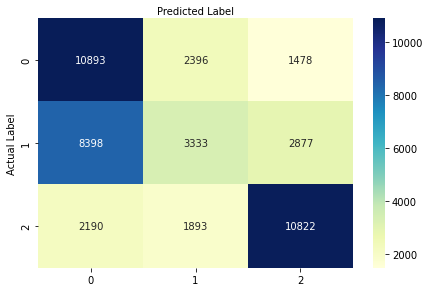

running on validation (val_apref_ds) set...


  0%|                                                                                         | 0/1325 [00:00<?, ?it/s]

val_apref_ds Loss: 0.8388 Accuracy: 0.6160


100%|██████████████████████████████████████████████████████████████████████████████| 1325/1325 [07:47<00:00,  2.83it/s]


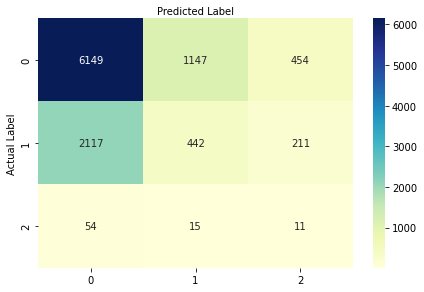

  0%|                                                                                         | 0/5535 [00:00<?, ?it/s]


Epoch 3/199
----------


C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  1%|█                                                                               | 75/5535 [00:42<51:51,  1.75it/s]

train Loss: 0.8838 Accuracy: 0.5625


  4%|██▊                                                                            | 195/5535 [01:50<50:40,  1.76it/s]

train Loss: 0.8823 Accuracy: 0.5479


  6%|████▍                                                                          | 315/5535 [02:58<49:04,  1.77it/s]

train Loss: 0.8763 Accuracy: 0.5552


  8%|██████▏                                                                        | 435/5535 [04:06<48:08,  1.77it/s]

train Loss: 0.8870 Accuracy: 0.5427


 10%|███████▉                                                                       | 555/5535 [05:14<47:20,  1.75it/s]

train Loss: 0.9047 Accuracy: 0.5115


 12%|█████████▋                                                                     | 675/5535 [06:22<46:22,  1.75it/s]

train Loss: 0.8662 Accuracy: 0.5719


 14%|███████████▎                                                                   | 795/5535 [07:30<44:44,  1.77it/s]

train Loss: 0.8634 Accuracy: 0.5281


 17%|█████████████                                                                  | 915/5535 [08:38<43:50,  1.76it/s]

train Loss: 0.8764 Accuracy: 0.5479


 19%|██████████████▌                                                               | 1035/5535 [09:46<42:52,  1.75it/s]

train Loss: 0.9047 Accuracy: 0.5177


 21%|████████████████▎                                                             | 1155/5535 [10:54<41:32,  1.76it/s]

train Loss: 0.8898 Accuracy: 0.5344


 23%|█████████████████▉                                                            | 1275/5535 [12:03<40:25,  1.76it/s]

train Loss: 0.8917 Accuracy: 0.5469


 25%|███████████████████▋                                                          | 1395/5535 [13:11<39:23,  1.75it/s]

train Loss: 0.8995 Accuracy: 0.5448


 27%|█████████████████████▎                                                        | 1515/5535 [14:18<38:07,  1.76it/s]

train Loss: 0.8664 Accuracy: 0.5458


 30%|███████████████████████                                                       | 1635/5535 [15:27<36:57,  1.76it/s]

train Loss: 0.8515 Accuracy: 0.5646


 32%|████████████████████████▋                                                     | 1755/5535 [16:34<35:52,  1.76it/s]

train Loss: 0.8623 Accuracy: 0.5646


 34%|██████████████████████████▍                                                   | 1875/5535 [17:43<34:37,  1.76it/s]

train Loss: 0.8985 Accuracy: 0.5167


 36%|████████████████████████████                                                  | 1995/5535 [18:51<33:28,  1.76it/s]

train Loss: 0.9119 Accuracy: 0.5344


 38%|█████████████████████████████▊                                                | 2115/5535 [19:59<32:11,  1.77it/s]

train Loss: 0.9171 Accuracy: 0.5042


 40%|███████████████████████████████▍                                              | 2235/5535 [21:07<31:16,  1.76it/s]

train Loss: 0.8698 Accuracy: 0.5448


 43%|█████████████████████████████████▏                                            | 2355/5535 [22:15<30:57,  1.71it/s]

train Loss: 0.9001 Accuracy: 0.5302


 45%|██████████████████████████████████▉                                           | 2475/5535 [23:23<28:52,  1.77it/s]

train Loss: 0.8744 Accuracy: 0.5521


 47%|████████████████████████████████████▌                                         | 2595/5535 [24:31<27:47,  1.76it/s]

train Loss: 1.0220 Accuracy: 0.5583


 49%|██████████████████████████████████████▎                                       | 2715/5535 [25:39<26:35,  1.77it/s]

train Loss: 0.8623 Accuracy: 0.5552


 51%|███████████████████████████████████████▉                                      | 2835/5535 [26:47<25:37,  1.76it/s]

train Loss: 0.9025 Accuracy: 0.5365


 53%|█████████████████████████████████████████▋                                    | 2955/5535 [27:56<24:27,  1.76it/s]

train Loss: 0.9032 Accuracy: 0.5229


 56%|███████████████████████████████████████████▎                                  | 3075/5535 [29:04<23:16,  1.76it/s]

train Loss: 0.8901 Accuracy: 0.5208


 58%|█████████████████████████████████████████████                                 | 3195/5535 [30:12<22:01,  1.77it/s]

train Loss: 0.9177 Accuracy: 0.5323


 60%|██████████████████████████████████████████████▋                               | 3315/5535 [31:20<20:55,  1.77it/s]

train Loss: 0.8680 Accuracy: 0.5417


 62%|████████████████████████████████████████████████▍                             | 3435/5535 [32:28<19:50,  1.76it/s]

train Loss: 0.8803 Accuracy: 0.5333


 64%|██████████████████████████████████████████████████                            | 3555/5535 [33:36<18:41,  1.77it/s]

train Loss: 0.8741 Accuracy: 0.5531


 66%|███████████████████████████████████████████████████▊                          | 3675/5535 [34:44<17:30,  1.77it/s]

train Loss: 0.8811 Accuracy: 0.5531


 69%|█████████████████████████████████████████████████████▍                        | 3795/5535 [35:52<16:28,  1.76it/s]

train Loss: 0.8804 Accuracy: 0.5448


 71%|███████████████████████████████████████████████████████▏                      | 3915/5535 [37:00<15:18,  1.76it/s]

train Loss: 0.8762 Accuracy: 0.5500


 73%|████████████████████████████████████████████████████████▊                     | 4035/5535 [38:08<14:06,  1.77it/s]

train Loss: 0.8925 Accuracy: 0.5542


 75%|██████████████████████████████████████████████████████████▌                   | 4155/5535 [39:16<13:03,  1.76it/s]

train Loss: 0.8829 Accuracy: 0.5469


 77%|████████████████████████████████████████████████████████████▏                 | 4275/5535 [40:24<11:55,  1.76it/s]

train Loss: 0.8861 Accuracy: 0.5354


 79%|█████████████████████████████████████████████████████████████▉                | 4395/5535 [41:32<10:45,  1.77it/s]

train Loss: 0.8748 Accuracy: 0.5698


 82%|███████████████████████████████████████████████████████████████▋              | 4515/5535 [42:40<09:36,  1.77it/s]

train Loss: 0.8760 Accuracy: 0.5323


 84%|█████████████████████████████████████████████████████████████████▎            | 4635/5535 [43:48<08:30,  1.76it/s]

train Loss: 0.8662 Accuracy: 0.5635


 86%|███████████████████████████████████████████████████████████████████           | 4755/5535 [44:56<07:24,  1.75it/s]

train Loss: 0.8742 Accuracy: 0.5469


 88%|████████████████████████████████████████████████████████████████████▋         | 4875/5535 [46:04<06:14,  1.76it/s]

train Loss: 0.9049 Accuracy: 0.5240


 90%|██████████████████████████████████████████████████████████████████████▍       | 4995/5535 [47:12<05:04,  1.77it/s]

train Loss: 0.8903 Accuracy: 0.5323


 92%|████████████████████████████████████████████████████████████████████████      | 5115/5535 [48:20<03:58,  1.76it/s]

train Loss: 0.8610 Accuracy: 0.5583


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5235/5535 [49:28<02:50,  1.76it/s]

train Loss: 0.9114 Accuracy: 0.5312


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5355/5535 [50:36<01:41,  1.78it/s]

train Loss: 0.8708 Accuracy: 0.5604


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5475/5535 [51:44<00:34,  1.76it/s]

train Loss: 0.8977 Accuracy: 0.5188


100%|██████████████████████████████████████████████████████████████████████████████| 5535/5535 [32:54<00:00,  2.80it/s]


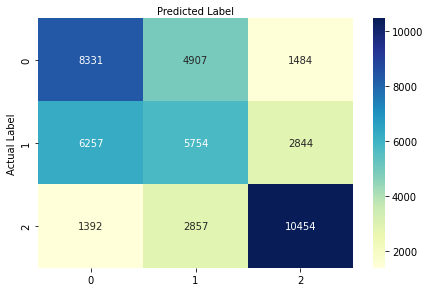

running on validation (val_apref_ds) set...


  0%|                                                                                         | 0/1325 [00:00<?, ?it/s]

val_apref_ds Loss: 0.8879 Accuracy: 0.5201


100%|██████████████████████████████████████████████████████████████████████████████| 1325/1325 [07:47<00:00,  2.83it/s]


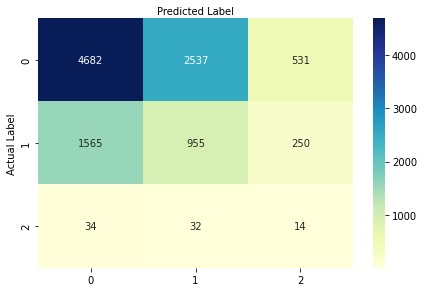

  0%|                                                                                         | 0/5535 [00:00<?, ?it/s]


Epoch 4/199
----------


C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  1%|▊                                                                               | 60/5535 [00:34<51:34,  1.77it/s]

train Loss: 0.8892 Accuracy: 0.5573


  3%|██▌                                                                            | 180/5535 [01:42<50:24,  1.77it/s]

train Loss: 0.8998 Accuracy: 0.5375


  5%|████▎                                                                          | 300/5535 [02:49<49:33,  1.76it/s]

train Loss: 0.8754 Accuracy: 0.5583


  8%|█████▉                                                                         | 420/5535 [03:58<48:12,  1.77it/s]

train Loss: 0.8573 Accuracy: 0.5708


 10%|███████▋                                                                       | 540/5535 [05:06<47:03,  1.77it/s]

train Loss: 0.8866 Accuracy: 0.5375


 12%|█████████▍                                                                     | 660/5535 [06:14<46:00,  1.77it/s]

train Loss: 0.9080 Accuracy: 0.5458


 14%|███████████▏                                                                   | 780/5535 [07:22<45:03,  1.76it/s]

train Loss: 0.8677 Accuracy: 0.5542


 16%|████████████▊                                                                  | 900/5535 [08:30<43:24,  1.78it/s]

train Loss: 0.8662 Accuracy: 0.5635


 18%|██████████████▎                                                               | 1020/5535 [09:38<42:53,  1.75it/s]

train Loss: 0.8866 Accuracy: 0.5563


 21%|████████████████                                                              | 1140/5535 [10:46<41:35,  1.76it/s]

train Loss: 0.8787 Accuracy: 0.5823


 23%|█████████████████▊                                                            | 1260/5535 [11:54<40:24,  1.76it/s]

train Loss: 0.8634 Accuracy: 0.5698


 25%|███████████████████▍                                                          | 1380/5535 [13:02<39:11,  1.77it/s]

train Loss: 0.9026 Accuracy: 0.5135


 27%|█████████████████████▏                                                        | 1500/5535 [14:10<38:15,  1.76it/s]

train Loss: 0.8882 Accuracy: 0.5667


 29%|██████████████████████▊                                                       | 1620/5535 [15:18<37:17,  1.75it/s]

train Loss: 0.8776 Accuracy: 0.5542


 31%|████████████████████████▌                                                     | 1740/5535 [16:26<35:39,  1.77it/s]

train Loss: 0.8913 Accuracy: 0.5406


 34%|██████████████████████████▏                                                   | 1860/5535 [17:34<34:46,  1.76it/s]

train Loss: 0.8996 Accuracy: 0.5302


 36%|███████████████████████████▉                                                  | 1980/5535 [18:42<33:30,  1.77it/s]

train Loss: 0.8838 Accuracy: 0.5417


 38%|█████████████████████████████▌                                                | 2100/5535 [19:50<32:31,  1.76it/s]

train Loss: 0.8589 Accuracy: 0.5521


 40%|███████████████████████████████▎                                              | 2220/5535 [20:58<31:13,  1.77it/s]

train Loss: 0.9064 Accuracy: 0.5531


 42%|████████████████████████████████▉                                             | 2340/5535 [22:06<30:16,  1.76it/s]

train Loss: 0.9061 Accuracy: 0.5292


 44%|██████████████████████████████████▋                                           | 2460/5535 [23:14<29:04,  1.76it/s]

train Loss: 0.8665 Accuracy: 0.5802


 47%|████████████████████████████████████▎                                         | 2580/5535 [24:22<27:41,  1.78it/s]

train Loss: 0.8747 Accuracy: 0.5479


 49%|██████████████████████████████████████                                        | 2700/5535 [25:30<26:45,  1.77it/s]

train Loss: 0.8994 Accuracy: 0.5573


 51%|███████████████████████████████████████▋                                      | 2820/5535 [26:38<25:33,  1.77it/s]

train Loss: 0.8750 Accuracy: 0.5437


 53%|█████████████████████████████████████████▍                                    | 2940/5535 [27:46<24:39,  1.75it/s]

train Loss: 0.8913 Accuracy: 0.5615


 55%|███████████████████████████████████████████                                   | 3060/5535 [28:54<23:29,  1.76it/s]

train Loss: 0.8840 Accuracy: 0.5542


 57%|████████████████████████████████████████████▊                                 | 3180/5535 [30:02<22:09,  1.77it/s]

train Loss: 0.8814 Accuracy: 0.5750


 60%|██████████████████████████████████████████████▌                               | 3300/5535 [31:10<21:15,  1.75it/s]

train Loss: 0.9083 Accuracy: 0.5344


 62%|████████████████████████████████████████████████▏                             | 3420/5535 [32:18<19:57,  1.77it/s]

train Loss: 0.8731 Accuracy: 0.5656


 64%|█████████████████████████████████████████████████▉                            | 3540/5535 [33:26<18:51,  1.76it/s]

train Loss: 0.8857 Accuracy: 0.5469


 66%|███████████████████████████████████████████████████▌                          | 3660/5535 [34:34<17:42,  1.76it/s]

train Loss: 0.8575 Accuracy: 0.5646


 68%|█████████████████████████████████████████████████████▎                        | 3780/5535 [35:42<16:33,  1.77it/s]

train Loss: 0.8856 Accuracy: 0.5500


 70%|██████████████████████████████████████████████████████▉                       | 3900/5535 [36:50<15:25,  1.77it/s]

train Loss: 0.8578 Accuracy: 0.5708


 73%|████████████████████████████████████████████████████████▋                     | 4020/5535 [37:58<14:15,  1.77it/s]

train Loss: 0.8502 Accuracy: 0.5604


 75%|██████████████████████████████████████████████████████████▎                   | 4140/5535 [39:06<13:15,  1.75it/s]

train Loss: 0.8922 Accuracy: 0.5625


 77%|████████████████████████████████████████████████████████████                  | 4260/5535 [40:14<12:05,  1.76it/s]

train Loss: 0.8759 Accuracy: 0.5521


 79%|█████████████████████████████████████████████████████████████▋                | 4380/5535 [41:22<10:57,  1.76it/s]

train Loss: 0.9139 Accuracy: 0.5198


 81%|███████████████████████████████████████████████████████████████▍              | 4500/5535 [42:30<09:47,  1.76it/s]

train Loss: 1.0836 Accuracy: 0.5458


 83%|█████████████████████████████████████████████████████████████████             | 4620/5535 [43:38<08:37,  1.77it/s]

train Loss: 0.8890 Accuracy: 0.5240


 86%|██████████████████████████████████████████████████████████████████▊           | 4740/5535 [44:46<07:29,  1.77it/s]

train Loss: 0.8764 Accuracy: 0.5406


 88%|████████████████████████████████████████████████████████████████████▍         | 4860/5535 [45:54<06:22,  1.77it/s]

train Loss: 0.8813 Accuracy: 0.5771


 90%|██████████████████████████████████████████████████████████████████████▏       | 4980/5535 [47:02<05:14,  1.77it/s]

train Loss: 0.9078 Accuracy: 0.5156


 92%|███████████████████████████████████████████████████████████████████████▊      | 5100/5535 [48:10<04:04,  1.78it/s]

train Loss: 0.8726 Accuracy: 0.5198


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5220/5535 [49:18<02:59,  1.76it/s]

train Loss: 0.8607 Accuracy: 0.5708


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5340/5535 [50:26<01:50,  1.77it/s]

train Loss: 0.8703 Accuracy: 0.5510


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5460/5535 [51:34<00:42,  1.76it/s]

train Loss: 0.8453 Accuracy: 0.5708


100%|██████████████████████████████████████████████████████████████████████████████| 5535/5535 [32:53<00:00,  2.80it/s]


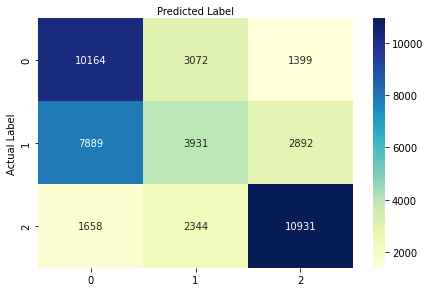

running on validation (val_apref_ds) set...


  0%|                                                                                         | 0/1325 [00:00<?, ?it/s]

val_apref_ds Loss: 0.8325 Accuracy: 0.6119


100%|██████████████████████████████████████████████████████████████████████████████| 1325/1325 [07:47<00:00,  2.83it/s]


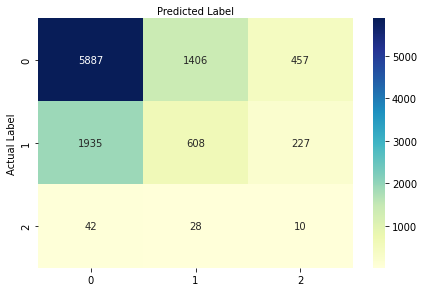

  0%|                                                                                         | 0/5535 [00:00<?, ?it/s]


Epoch 5/199
----------


C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  1%|▋                                                                             | 45/5535 [00:37<1:16:25,  1.20it/s]

train Loss: 0.9546 Accuracy: 0.5052


  3%|██▎                                                                          | 165/5535 [02:18<1:15:20,  1.19it/s]

train Loss: 1.0503 Accuracy: 0.4125


  5%|███▉                                                                         | 285/5535 [03:59<1:13:25,  1.19it/s]

train Loss: 1.1172 Accuracy: 0.3500


  7%|█████▋                                                                       | 405/5535 [05:40<1:11:43,  1.19it/s]

train Loss: 1.0982 Accuracy: 0.3594


  9%|███████▎                                                                     | 525/5535 [07:21<1:09:59,  1.19it/s]

train Loss: 1.0994 Accuracy: 0.3531


 12%|████████▉                                                                    | 645/5535 [09:01<1:08:22,  1.19it/s]

train Loss: 1.1009 Accuracy: 0.3083


 14%|██████████▋                                                                  | 765/5535 [10:42<1:06:55,  1.19it/s]

train Loss: 1.0983 Accuracy: 0.3469


 16%|████████████▎                                                                | 885/5535 [12:23<1:05:13,  1.19it/s]

train Loss: 1.1005 Accuracy: 0.3333


 18%|█████████████▊                                                              | 1005/5535 [14:04<1:03:34,  1.19it/s]

train Loss: 1.1007 Accuracy: 0.3115


 20%|███████████████▍                                                            | 1125/5535 [15:45<1:01:56,  1.19it/s]

train Loss: 1.1003 Accuracy: 0.3302


 22%|█████████████████                                                           | 1245/5535 [17:26<1:00:24,  1.18it/s]

train Loss: 1.0996 Accuracy: 0.3354


 25%|███████████████████▏                                                          | 1365/5535 [19:07<58:53,  1.18it/s]

train Loss: 1.1005 Accuracy: 0.3094


 27%|████████████████████▉                                                         | 1485/5535 [20:48<57:02,  1.18it/s]

train Loss: 1.0986 Accuracy: 0.3469


 29%|██████████████████████▌                                                       | 1605/5535 [22:29<55:19,  1.18it/s]

train Loss: 1.0982 Accuracy: 0.3500


 31%|████████████████████████▎                                                     | 1725/5535 [24:10<53:49,  1.18it/s]

train Loss: 1.0990 Accuracy: 0.3552


 33%|██████████████████████████                                                    | 1845/5535 [25:51<51:51,  1.19it/s]

train Loss: 1.0997 Accuracy: 0.3198


 36%|███████████████████████████▋                                                  | 1965/5535 [27:32<50:27,  1.18it/s]

train Loss: 1.0986 Accuracy: 0.3344


 38%|█████████████████████████████▍                                                | 2085/5535 [29:13<48:22,  1.19it/s]

train Loss: 1.0973 Accuracy: 0.3417


 40%|███████████████████████████████                                               | 2205/5535 [30:54<46:48,  1.19it/s]

train Loss: 1.1020 Accuracy: 0.3208


 42%|████████████████████████████████▊                                             | 2325/5535 [32:35<45:08,  1.18it/s]

train Loss: 1.1004 Accuracy: 0.3365


 44%|██████████████████████████████████▍                                           | 2445/5535 [34:15<43:19,  1.19it/s]

train Loss: 1.0995 Accuracy: 0.3271


 46%|████████████████████████████████████▏                                         | 2565/5535 [35:56<41:47,  1.18it/s]

train Loss: 1.0996 Accuracy: 0.3281


 49%|█████████████████████████████████████▊                                        | 2685/5535 [37:37<40:08,  1.18it/s]

train Loss: 1.0987 Accuracy: 0.3312


 51%|███████████████████████████████████████▌                                      | 2805/5535 [39:18<38:25,  1.18it/s]

train Loss: 1.0980 Accuracy: 0.3438


 53%|█████████████████████████████████████████▏                                    | 2925/5535 [40:59<36:46,  1.18it/s]

train Loss: 1.0981 Accuracy: 0.3604


 55%|██████████████████████████████████████████▉                                   | 3045/5535 [42:40<35:07,  1.18it/s]

train Loss: 1.0983 Accuracy: 0.3333


 57%|████████████████████████████████████████████▌                                 | 3165/5535 [44:21<33:19,  1.19it/s]

train Loss: 1.1008 Accuracy: 0.3104


 59%|██████████████████████████████████████████████▎                               | 3285/5535 [46:02<31:31,  1.19it/s]

train Loss: 1.0986 Accuracy: 0.3625


 62%|███████████████████████████████████████████████▉                              | 3405/5535 [47:43<29:55,  1.19it/s]

train Loss: 1.0994 Accuracy: 0.3312


 64%|█████████████████████████████████████████████████▋                            | 3525/5535 [49:24<28:07,  1.19it/s]

train Loss: 1.0992 Accuracy: 0.3500


 66%|███████████████████████████████████████████████████▎                          | 3645/5535 [51:05<26:41,  1.18it/s]

train Loss: 1.0992 Accuracy: 0.3375


 68%|█████████████████████████████████████████████████████                         | 3765/5535 [52:46<24:52,  1.19it/s]

train Loss: 1.0991 Accuracy: 0.3344


 70%|██████████████████████████████████████████████████████▋                       | 3885/5535 [54:27<23:02,  1.19it/s]

train Loss: 1.0995 Accuracy: 0.3385


 72%|████████████████████████████████████████████████████████▍                     | 4005/5535 [56:08<21:25,  1.19it/s]

train Loss: 1.0981 Accuracy: 0.3198


 75%|██████████████████████████████████████████████████████████▏                   | 4125/5535 [57:49<19:44,  1.19it/s]

train Loss: 1.0998 Accuracy: 0.3198


 77%|███████████████████████████████████████████████████████████▊                  | 4245/5535 [59:29<18:00,  1.19it/s]

train Loss: 1.0978 Accuracy: 0.3479


 79%|███████████████████████████████████████████████████████████▉                | 4365/5535 [1:01:10<16:22,  1.19it/s]

train Loss: 1.0995 Accuracy: 0.3583


 81%|█████████████████████████████████████████████████████████████▌              | 4485/5535 [1:02:51<14:42,  1.19it/s]

train Loss: 1.0971 Accuracy: 0.3438


 83%|███████████████████████████████████████████████████████████████▏            | 4605/5535 [1:04:32<13:00,  1.19it/s]

train Loss: 1.1005 Accuracy: 0.3312


 85%|████████████████████████████████████████████████████████████████▉           | 4725/5535 [1:06:13<11:19,  1.19it/s]

train Loss: 1.1001 Accuracy: 0.3052


 88%|██████████████████████████████████████████████████████████████████▌         | 4845/5535 [1:07:54<09:42,  1.19it/s]

train Loss: 1.1005 Accuracy: 0.3344


 90%|████████████████████████████████████████████████████████████████████▏       | 4965/5535 [1:09:35<07:58,  1.19it/s]

train Loss: 1.0982 Accuracy: 0.3615


 92%|█████████████████████████████████████████████████████████████████████▊      | 5085/5535 [1:11:16<06:17,  1.19it/s]

train Loss: 1.0996 Accuracy: 0.3229


 94%|███████████████████████████████████████████████████████████████████████▍    | 5205/5535 [1:12:57<04:36,  1.19it/s]

train Loss: 1.0988 Accuracy: 0.3448


 96%|█████████████████████████████████████████████████████████████████████████   | 5325/5535 [1:14:38<02:56,  1.19it/s]

train Loss: 1.0984 Accuracy: 0.3552


 98%|██████████████████████████████████████████████████████████████████████████▊ | 5445/5535 [1:16:19<01:15,  1.19it/s]

train Loss: 1.0990 Accuracy: 0.3260


100%|██████████████████████████████████████████████████████████████████████████████| 5535/5535 [32:53<00:00,  2.80it/s]


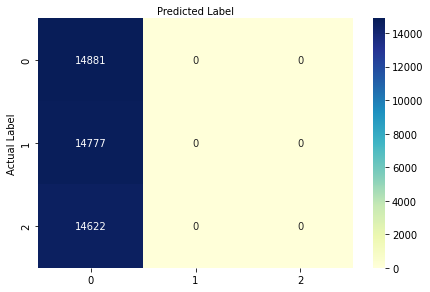

running on validation (val_apref_ds) set...


  0%|                                                                                         | 0/1325 [00:00<?, ?it/s]

val_apref_ds Loss: 1.0913 Accuracy: 0.7307


100%|██████████████████████████████████████████████████████████████████████████████| 1325/1325 [07:47<00:00,  2.84it/s]


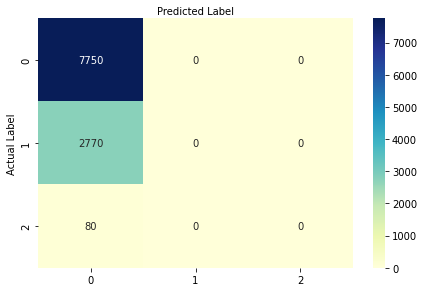

  0%|                                                                                         | 0/5535 [00:00<?, ?it/s]


Epoch 6/199
----------


C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  1%|▍                                                                             | 30/5535 [00:25<1:17:27,  1.18it/s]

train Loss: 1.0993 Accuracy: 0.3115


  3%|██                                                                           | 150/5535 [02:06<1:15:57,  1.18it/s]

train Loss: 1.0984 Accuracy: 0.3396


  5%|███▊                                                                         | 270/5535 [03:47<1:14:12,  1.18it/s]

train Loss: 1.0980 Accuracy: 0.3406


  7%|█████▍                                                                       | 390/5535 [05:28<1:11:57,  1.19it/s]

train Loss: 1.0987 Accuracy: 0.3333


  9%|███████                                                                      | 510/5535 [07:09<1:10:21,  1.19it/s]

train Loss: 1.0984 Accuracy: 0.3500


 11%|████████▊                                                                    | 630/5535 [08:50<1:08:51,  1.19it/s]

train Loss: 1.0995 Accuracy: 0.3260


 14%|██████████▍                                                                  | 750/5535 [10:31<1:07:13,  1.19it/s]

train Loss: 1.0992 Accuracy: 0.3396


 16%|████████████                                                                 | 870/5535 [12:12<1:05:06,  1.19it/s]

train Loss: 1.0995 Accuracy: 0.3385


 18%|█████████████▊                                                               | 990/5535 [13:53<1:04:02,  1.18it/s]

train Loss: 1.0995 Accuracy: 0.3104


 20%|███████████████▏                                                            | 1110/5535 [15:33<1:01:50,  1.19it/s]

train Loss: 1.0989 Accuracy: 0.3417


 22%|████████████████▉                                                           | 1230/5535 [17:15<1:00:43,  1.18it/s]

train Loss: 1.0993 Accuracy: 0.3198


 24%|███████████████████                                                           | 1350/5535 [18:55<58:36,  1.19it/s]

train Loss: 1.0991 Accuracy: 0.3354


 27%|████████████████████▋                                                         | 1470/5535 [20:36<57:10,  1.19it/s]

train Loss: 1.0990 Accuracy: 0.3198


 29%|██████████████████████▍                                                       | 1590/5535 [22:17<55:15,  1.19it/s]

train Loss: 1.0984 Accuracy: 0.3542


 31%|████████████████████████                                                      | 1710/5535 [23:58<53:41,  1.19it/s]

train Loss: 1.0982 Accuracy: 0.3469


 33%|█████████████████████████▊                                                    | 1830/5535 [25:39<52:03,  1.19it/s]

train Loss: 1.0982 Accuracy: 0.3615


 35%|███████████████████████████▍                                                  | 1950/5535 [27:20<50:23,  1.19it/s]

train Loss: 1.0992 Accuracy: 0.3219


 37%|█████████████████████████████▏                                                | 2070/5535 [29:02<48:54,  1.18it/s]

train Loss: 1.0990 Accuracy: 0.3260


 40%|██████████████████████████████▊                                               | 2190/5535 [30:43<46:42,  1.19it/s]

train Loss: 1.0977 Accuracy: 0.3583


 42%|████████████████████████████████▌                                             | 2310/5535 [32:24<45:27,  1.18it/s]

train Loss: 1.0988 Accuracy: 0.3396


 44%|██████████████████████████████████▏                                           | 2430/5535 [34:05<43:28,  1.19it/s]

train Loss: 1.0987 Accuracy: 0.3240


 46%|███████████████████████████████████▉                                          | 2550/5535 [35:46<41:55,  1.19it/s]

train Loss: 1.0988 Accuracy: 0.3198


 48%|█████████████████████████████████████▋                                        | 2670/5535 [37:27<40:09,  1.19it/s]

train Loss: 1.0984 Accuracy: 0.3240


 50%|███████████████████████████████████████▎                                      | 2790/5535 [39:08<38:20,  1.19it/s]

train Loss: 1.0983 Accuracy: 0.3354


 53%|█████████████████████████████████████████                                     | 2910/5535 [40:49<36:51,  1.19it/s]

train Loss: 1.0985 Accuracy: 0.3417


 55%|██████████████████████████████████████████▋                                   | 3030/5535 [42:30<35:03,  1.19it/s]

train Loss: 1.0987 Accuracy: 0.3229


 57%|████████████████████████████████████████████▍                                 | 3150/5535 [44:11<33:24,  1.19it/s]

train Loss: 1.0991 Accuracy: 0.3198


 59%|██████████████████████████████████████████████                                | 3270/5535 [45:52<31:45,  1.19it/s]

train Loss: 1.0982 Accuracy: 0.3375


 61%|███████████████████████████████████████████████▊                              | 3390/5535 [47:33<30:00,  1.19it/s]

train Loss: 1.0985 Accuracy: 0.3094


 63%|█████████████████████████████████████████████████▍                            | 3510/5535 [49:14<28:24,  1.19it/s]

train Loss: 1.0971 Accuracy: 0.3521


 66%|███████████████████████████████████████████████████▏                          | 3630/5535 [50:55<26:43,  1.19it/s]

train Loss: 1.0985 Accuracy: 0.3458


 68%|████████████████████████████████████████████████████▊                         | 3750/5535 [52:36<24:53,  1.20it/s]

train Loss: 1.0996 Accuracy: 0.3375


 70%|██████████████████████████████████████████████████████▌                       | 3870/5535 [54:17<23:29,  1.18it/s]

train Loss: 1.0998 Accuracy: 0.3198


 72%|████████████████████████████████████████████████████████▏                     | 3990/5535 [55:58<21:39,  1.19it/s]

train Loss: 1.1215 Accuracy: 0.3354


 74%|█████████████████████████████████████████████████████████▉                    | 4110/5535 [57:39<19:59,  1.19it/s]

train Loss: 1.0992 Accuracy: 0.3271


 76%|███████████████████████████████████████████████████████████▌                  | 4230/5535 [59:20<18:21,  1.19it/s]

train Loss: 1.0979 Accuracy: 0.3594


 79%|███████████████████████████████████████████████████████████▋                | 4350/5535 [1:01:01<16:35,  1.19it/s]

train Loss: 1.0981 Accuracy: 0.3229


 81%|█████████████████████████████████████████████████████████████▍              | 4470/5535 [1:02:42<14:59,  1.18it/s]

train Loss: 1.1075 Accuracy: 0.3417


 83%|███████████████████████████████████████████████████████████████             | 4590/5535 [1:04:20<13:18,  1.18it/s]

train Loss: 1.0990 Accuracy: 0.3250


 85%|████████████████████████████████████████████████████████████████▋           | 4710/5535 [1:06:01<11:31,  1.19it/s]

train Loss: 1.0997 Accuracy: 0.3302


 86%|█████████████████████████████████████████████████████████████████▌          | 4776/5535 [1:06:57<10:38,  1.19it/s]


KeyboardInterrupt: 

In [8]:
#####################################################
#           Logging
#####################################################


 ### Train ###

cur_time = datetime.now()
cur_time_str = cur_time.strftime("time_%d_%m_%Y_%H_%M_%S")
experiment_name = cur_time_str

writer = SummaryWriter('logs/Morph2Diff/unified/iter/' + experiment_name) 

model_path = 'weights/Morph2Diff/unified/iter/' + experiment_name
if not os.path.exists(model_path):
    os.makedirs(model_path)


shutil.copyfile("range_classification__config.py", model_path + "/config.py")


#####################################################
#           Training
#####################################################

best_diff_model = train_diff_cls_model_iter(
    model,
    criterion,
    optimizer,
    scheduler,
    data_loaders,
    dataset_sizes,
    device,
    writer,
    model_path,
    num_epochs=cfg.NUM_EPOCHS,
    unfreeze_feature_ext_epoch=cfg.UNFREEZE_FEATURE_EXT_EPOCH,
    unfreeze_feature_ext_on_rlvnt_epoch=cfg.UNFREEZE_FEATURE_EXT_ON_RLVNT_EPOCH,
    validate_at_k=cfg.VALIDATION_PERIOD_ITERS,
    validate_at_end_of_epoch=cfg.VALIDATE_AT_END_OF_EPOCH
)


print('saving best model')

FINAL_MODEL_FILE = os.path.join(model_path, "weights.pt")
torch.save(best_diff_model.state_dict(), FINAL_MODEL_FILE)

In [ ]:
self.batst_set_indexes
